In [1]:
import matplotlib.pyplot as plt
import os
import cv2
from frame_helpers import colorize, convert_to_bgra_if_required
from pyk4a import PyK4APlayback
from frame_generator import UNet

In [2]:
# print mkv recording length
def info(playback: PyK4APlayback):
    print(f"Record length: {playback.length / 1000000: 0.2f} sec")

Record length:  10.20 sec
[2023-11-26 20:12:59.095] [error] [t=15337] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/tewrapper/tewrapper.c (61): transform_engine_start_helper(). Transform engine create and initialize failed with error code: 204.
HERE: None
[2023-11-26 20:12:59.095] [error] [t=15337] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/tewrapper/tewrapper.c (68): teresult == K4A_DEPTH_ENGINE_RESULT_SUCCEEDED returned failure in transform_engine_start_helper()
[2023-11-26 20:12:59.095] [error] [t=15337] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/tewrapper/tewrapper.c (86): transform_engine_start_helper(tewrapper) returned failure in transform_engine_thread()
[2023-11-26 20:12:59.095] [error] [t=15304] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/tewrapper/tewrapper.c (313): tewrapper_create(). Transform Engine thread failed to start
[2023-11-26 20:12:59.095] [error] [t=15304] /__w/1/s/extern/Azure-Kinect-Sensor-SDK/src/transformation/transformation.c (637): transformation_context->t

TypeError: 'NoneType' object is not subscriptable

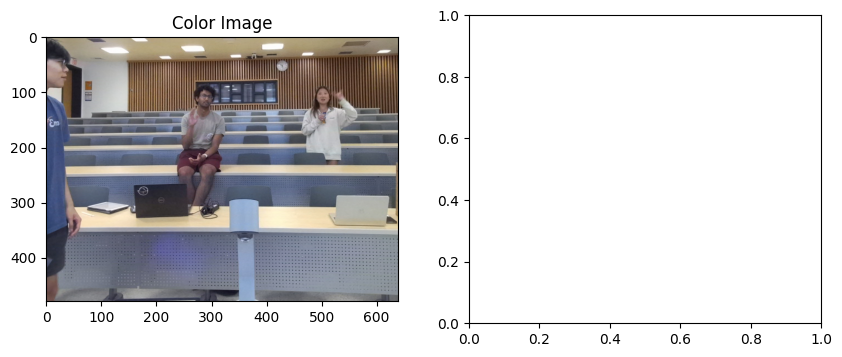

In [3]:
# Load an MKV file
if os.path.exists("/home/orin/Documents/FH12_23-24/FH12-EdgeMapper/comm-test/frame/ecj1204_2023-11-7.mkv"):
    mkv_file = "/home/orin/Documents/FH12_23-24/FH12-EdgeMapper/comm-test/frame/ecj1204_2023-11-7.mkv"
else:
    print("That path doesn't exist bruh lol")
    exit()

playback = PyK4APlayback(mkv_file)
playback.open()
playback.seek(24000000) # in microseconds, aka 5 seconds
info(playback) # prints the recording length

# print(type(playback))

# model = UNet().to(torch.device('cuda'))

# checkpoint = torch.load('epoch_250.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# l1_criterion = torch.nn.L1Loss()

# model.eval()

while True:
    try:
        capture = playback.get_next_capture()
      
        plt.figure(figsize=(15,4))

        if capture.color is None:
            print("No capture color")
        if capture.color is not None:
            # shows the original RGB photo, not cropped 
            # plt.imshow(cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB))
            # plt.show()

            plt.subplot(1,4,1)
            img_color = cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB)[120:600, 320:960, 0:3]
            print(img_color.shape)
            # img_color = cv2.resize(cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB)[80:720, 446: 926, 0:3], (640, 480))
            plt.imshow(img_color)
            plt.title ("Color Image")

        if capture.depth is None:
            print("No capture depth")
        if capture.depth is not None:
            # shows the original depth photo, not cropped 
            # plt.imshow(center_crop(cv2.cvtColor(colorize(capture.depth, (None, 5000)), cv2.COLOR_BGR2RGB), (480,640)))
            # plt.show()
            print(f"HERE: {capture.transformed_depth}")

            plt.subplot(1,4,2)
            # transformed frame aligns the depth frame with the color frame. It is able do this through the capture
            img_depth = capture.transformed_depth[120:600, 320:960]
            plt.imshow(img_depth)
            plt.title("Depth image")
            plt.subplot(1,4,3)
            mask = (img_depth == 0).astype(np.uint8)
            inpainted = cv2.inpaint(img_depth, mask, 2, flags=cv2.INPAINT_TELEA)
            # img_depth = cv2.resize(capture.transformed_depth[240:720, 286: 926], (640, 480))
            plt.imshow(inpainted)
            plt.title("Inpainted image")

            plt.subplot(1, 4, 4)

            invalid_mask = img_depth == 0

            # Create coordinates for valid and invalid pixels
            rows, cols = np.indices(img_depth.shape)
            valid_coords = np.column_stack((rows[~invalid_mask], cols[~invalid_mask]))
            invalid_coords = np.column_stack((rows[invalid_mask], cols[invalid_mask]))

            # Values of valid pixels
            valid_values = img_depth[~invalid_mask]

            # Use griddata to interpolate missing values (linear)
            zi = interpolate.griddata(valid_coords, valid_values, invalid_coords, method='linear', fill_value=0)

            # Replace invalid values with interpolated values
            img_depth[invalid_mask] = zi

            mask = (img_depth == 0).astype(np.uint8)
            if np.any(mask):
                print(np.count_nonzero(mask))
                img_depth = cv2.inpaint(img_depth, mask, 2, flags=cv2.INPAINT_TELEA)

            plt.imshow(img_depth)
            plt.title("Interpolated + inpainted image")

        # img_color = img_color.to(torch.device('cuda'))

        plt.suptitle("Capture at {} s".format(float(capture.color_timestamp_usec / 1000000)))
        plt.show()
        break

        # does not wait for a key press to get the next capture. 
        # key = cv2.waitKey(0)
        # if key != -1:
        #     break
    except EOFError:
        break  

# Release OpenCV windows
cv2.destroyAllWindows()
playback.close()



Text(0.5, 1.0, 'Inpainted image')

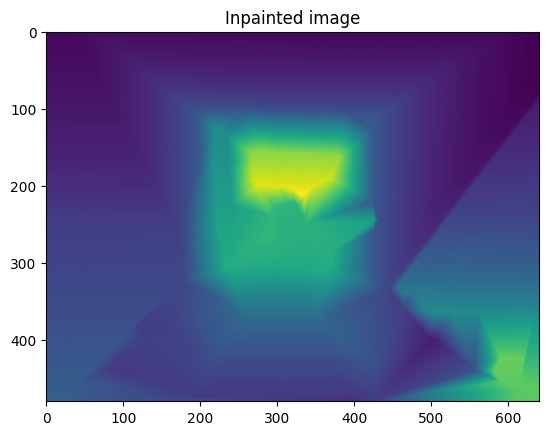

In [40]:
mask = (img_depth == 0).astype(np.uint8)
inpainted = cv2.inpaint(img_depth, mask, 2, flags=cv2.INPAINT_TELEA)
# img_depth = cv2.resize(capture.transformed_depth[240:720, 286: 926], (640, 480))
plt.imshow(inpainted)
plt.title("Inpainted image")

In [12]:
import torch
import h5py
import numpy as np
import random

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    """
    Customized DataSet for grabbing images. DataLoader wraps around this Dataset class to generate batches.

    Args:
        Dataset (torch.utils.Dataset): torch.utils.data.Dataset superclass.
    """
    def __init__(self, data, labels):
        """
        Initialize a CustomDataset using input tensors and label tensors.

        Args:
            data (list of list of torch.Tensor): Input tensors.
            labels (list of torch.Tensor): Label tensors.
        """
        self.data = data
        self.labels = labels
        self.transform = transforms.RandomHorizontalFlip()

    def __len__(self):
        """
        Returns the length of the entire Dataset.

        Returns:
            integer: Length of CustomDataset. 
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a tuple of the input tensors and ground truth tensors based on index.

        Args:
            idx (integer): The accessed index.

        Returns:
            tuple: A tuple of the input and ground truth tensors.
                - torch.Tensor: Input tensor.
                - torch.Tensor: Ground truth tensor. 
        """
        
        img = self.data[idx]
        truth = self.labels[idx]
        
        if self.transform:
            # to_pil = transforms.ToPILImage()
            # to_tensor = transforms.ToTensor()
            
            # img = to_pil(img)
            # img = self.transform(img)
            # img = to_tensor(img)
            p = random.random()
            if p >.5:
                img = torch.flip(img, dims=[2])
                truth = torch.flip(truth, dims=[2])
            
        return img, truth

def create_loader(input, labels, bs, workers=1):
    """
    Returns a DataLoader using CustomDataset. 
    Workers and batch size can also be specified.
    
    Args:
        input (list of torch.Tensor): A list of input PyTorch tensors.
        labels (list of torch.Tensor): A list of label PyTorch tensors.
        bs (integer): Specified batch size of DataLoader.
        workers (integer): Specified number of workers for DataLoader.
        
    Returns:
        torch.utils.data.DataLoader: DataLoader that can get batches of paired input and label tensors.
    """
    
    dataset = CustomDataset(input, labels)
    if workers == 1:
        loader = DataLoader(dataset, batch_size=bs, shuffle=True)
    else:
        loader = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=workers)
    return loader
    

def get_tensors(mat_dir): 
    """
    Creates tensors given a path to the nyuv2 .mat file. 
    This method pulls from RGB images to create input tensors and
    pulls from the depth maps to create label tensors.
    This outputs an approximate 80-20 train-test-split.

    Args:
        mat_dir (string): Path to the specified nyuv2 .mat file.

    Returns:
        tuple: A tuple of lists of tensors.
            - list of torch.Tensor: Input training tensors.
            - list of torch.Tensor: Ground truth training tensors.
            - list of torch.Tensor: Input validation tensors.
            - list of torch.Tensor: Ground truth validation tensors.
    """
    mat_file = h5py.File('nyu_depth_v2_labeled.mat', 'r')
    # rgb_images = mat_file['images'][:]
    # depth_images = mat_file['depths'][:]
    
    X_train = mat_file['images'][0:50].astype(np.uint8)
    X_test = mat_file['images'][1400::].astype(np.uint8)
    y_train = mat_file['depths'][0:50].astype(np.uint8)
    y_test = depth_images[1150::].astype(np.uint8)
    
    transform = transforms.ToTensor()

    X_train_tensors = []
    for x in X_train:
        x = transform(x)
        x = x.transpose(0,1)
        x = x.transpose(1,2)
        X_train_tensors.append(x)

    X_test_tensors = []
    for x in X_test:
        x = transform(x)
        x = x.transpose(0,1)
        x = x.transpose(1,2)
        X_test_tensors.append(x)

    train_max = 0

    y_train_tensors = []
    for y in y_train:
        y = transform(y)
        train_max = torch.max(y) if torch.max(y) > train_max else train_max
        y_train_tensors.append(y / train_max)
        
    test_max = 0

    y_test_tensors = []
    for y in y_test:
        y = transform(y)
        test_max = torch.max(y) if torch.max(y) > test_max else test_max
        y_test_tensors.append(y / test_max)
    
    return X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors

def meanstd(tensors):
    """
    Calculates the mean and standard deviation per channel given a list of tensors.
    tensors is assumed to be an RGB image with 3 channels.

    Args:
        tensors (list of a list of torch.Tensor): A list of lists containing tensors. Each list is considered a channel.

    Returns:
        tuple: A tuple of mean and standard deviation.
            - tuple: The means of each respective channel.
                - float: The mean of the first channel (R).
                - float: The mean of the second channel (G).
                - float: The mean of the third channel (B).
            - tuple: The standard deviations of each respective channel.
                - float: The standard deviation of the first channel (R).
                - float: The standard deviation of the second channel (G).
                - float: The standard deviation of the third channel (B).
    """
    mean = [0, 0, 0]
    std = [0, 0, 0]
    for t in tensors:
        mean[0] += torch.sum(t[0, :, :]).item()
        mean[1] += torch.sum(t[1, :, :]).item()
        mean[2] += torch.sum(t[2, :, :]).item()
        
    mean = tuple(m / (len(tensors) * 640 * 480) for m in mean)
    
    
    for t in tensors:
        red_diff = (t[0, :, :] - mean[0]) ** 2    
        green_diff = (t[1, :, :] - mean[1]) ** 2
        blue_diff = (t[2, :, :] - mean[2]) ** 2
        
        std[0] += torch.sum(red_diff).item()
        std[1] += torch.sum(green_diff).item()
        std[2] += torch.sum(blue_diff).item()
    
    std = tuple(s / (len(tensors) * 640 * 480) for s in std)
    
    return mean, std

def normalize(images):
    """
    Given RGB images, returns normalized tensors using mean and standard deviation.

    Args:
        images (list of list of np.uint8): RGB images in the form of np.uint8 lists. 

    Returns:
        list of list of torch.Tensor: Returns a normalized list of list of tensors.
    """
    mean, std = meanstd(images)

    pipeline = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ])

    tensors = []
    for x in images:
        x = np.transpose(x, (1, 2, 0))
        x = pipeline(x)
        tensors.append(x)
    
    return tensors

done
Now using device: cuda
Put model on device
tensor([[0.3748, 0.3748, 0.3748,  ..., 0.3701, 0.3699, 0.3698],
        [0.3758, 0.3758, 0.3759,  ..., 0.3712, 0.3709, 0.3708],
        [0.3770, 0.3771, 0.3771,  ..., 0.3722, 0.3720, 0.3720],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


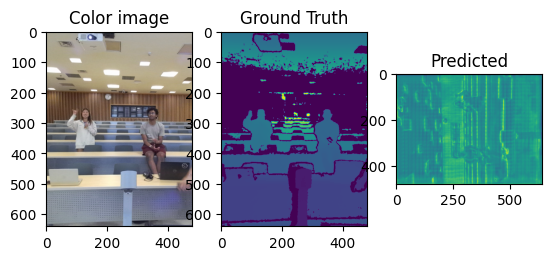

tensor([[[[ 0.0011,  0.0009,  0.0005,  ...,  0.0037,  0.0040,  0.0062],
          [-0.0039, -0.0069, -0.0041,  ...,  0.0004, -0.0015,  0.0027],
          [-0.0069, -0.0036, -0.0003,  ...,  0.0031,  0.0031,  0.0052],
          ...,
          [ 0.0086,  0.0212,  0.0233,  ...,  0.0174,  0.0203,  0.0254],
          [ 0.0327,  0.0302,  0.0270,  ...,  0.0172,  0.0184,  0.0227],
          [ 0.0244,  0.0235,  0.0259,  ...,  0.0195,  0.0233,  0.0278]]]],
       device='cuda:0')
Model ran for batch 0
CPU time: 0.0029062880003039027, GPU time: 0.05373673699978099, Total time: 0.05664302500008489


In [11]:
# import cv as mkv_reader
import matplotlib.pyplot as plt
from matplotlib import image
import os
import cv2
# from frame_helpers import colorize, convert_to_bgra_if_required
# from pyk4a import PyK4APlayback
import h5py
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import random
import argparse
import time
# from unet.model import UNet

import torch
from torch import nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

class CustomDataset(Dataset):
    """
    Customized DataSet for grabbing images. DataLoader wraps around this Dataset class to generate batches.

    Args:
        Dataset (torch.utils.Dataset): torch.utils.data.Dataset superclass.
    """
    def __init__(self, data, labels):
        """
        Initialize a CustomDataset using input tensors and label tensors.

        Args:
            data (list of list of torch.Tensor): Input tensors.
            labels (list of torch.Tensor): Label tensors.
        """
        self.data = data
        self.labels = labels
        self.transform = transforms.RandomHorizontalFlip()

    def __len__(self):
        """
        Returns the length of the entire Dataset.

        Returns:
            integer: Length of CustomDataset. 
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a tuple of the input tensors and ground truth tensors based on index.

        Args:
            idx (integer): The accessed index.

        Returns:
            tuple: A tuple of the input and ground truth tensors.
                - torch.Tensor: Input tensor.
                - torch.Tensor: Ground truth tensor. 
        """
        
        img = self.data[idx]
        truth = self.labels[idx]
        
        if self.transform:
            # to_pil = transforms.ToPILImage()
            # to_tensor = transforms.ToTensor()
            
            # img = to_pil(img)
            # img = self.transform(img)
            # img = to_tensor(img)
            p = random.random()
            if p >.5:
                img = torch.flip(img, dims=[2])
                truth = torch.flip(truth, dims=[2])
            
        return img, truth

# def info(playback: PyK4APlayback):
#     print(f"Record length: {playback.length / 1000000: 0.2f} sec")
          
# Load an MKV file
# def create_frames(path: str):
#     # Load an MKV file
#     if os.path.exists(f"{path}"):
#         mkv_file = f"{path}"
#     else:
#         print("That path doesn't exist bruh lol")
#         exit()

#     playback = PyK4APlayback(mkv_file)
#     playback.open()
#     playback.seek(5000000) # in microseconds, aka 5 seconds
#     info(playback) # prints the recording length

#     # print(type(playback))
#     # Create a new HDF5 file
#     file = h5py.File('output_1.h5', 'w')

#     # Create datasets for RGB images and depth maps
#     rgb_images = file.create_dataset('images', (0, 640, 480, 3), maxshape=(None, 640,480, 3))
#     depth_images = file.create_dataset('depths', (0, 640, 480), maxshape=(None, 640, 480))

#     i = 0
#     while True:
#         try:
#             capture = playback.get_next_capture()

#             if capture.color is not None:
#                 img_color = cv2.resize(cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB)[80:720, 446: 926, 0:3], (480, 640))

#                 # Append the RGB image to the dataset
#                 rgb_images.resize(i + 1, axis=0)
#                 rgb_images[i] = img_color

#             if capture.depth is not None:
#                 img_depth = cv2.resize(capture.transformed_depth[80:720, 446: 926], (480, 640))

#                 # Append the depth map to the dataset
#                 depth_images.resize(i + 1, axis=0)
#                 depth_images[i] = img_depth

#             i += 1

#             # key = cv2.waitKey(0)
#             # if key != -1:
#             #     break
#         except EOFError:
#             break

#     # Close the HDF5 file
#     file.close()

#     # Close the MKV file
#     playback.close()

def create_data_set(file_name):
    mat_file = h5py.File(f'{file_name}', 'r')
    rgb_images = mat_file['images'][:]
    depth_images = mat_file['depths'][:]

    transform = transforms.ToTensor()
    X_train = rgb_images
    y_train = depth_images

    X_train_tensors = []
    for x in X_train:
        x = transform(x)
        X_train_tensors.append(x)
    y_train_tensors = []
    train_max = 0
    for y in y_train:
        y = transform(y)
        train_max = torch.max(y) if torch.max(y) > train_max else train_max
        y_train_tensors.append(y / train_max)
    mat_file.close()

    return X_train_tensors, y_train_tensors

def create_data_loader(x, y):
    dataset = CustomDataset(x, y)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    return loader
    

def main(path: str):
    # create_frames(f"{path}")
    mat_file = h5py.File('nyu_depth_v2_labeled.mat', 'r')

    x, y = create_data_set("output_1.h5")
    loader = create_data_loader(x, y)
    print("done")
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    model_path = "/home/orin/Documents/FH12_23-24/FH12-EdgeMapper/epoch_250.pt"
    print(f"Now using device: {device}")
    model = UNet().to(torch.device(device))
    model.load_state_dict(torch.load(f'{model_path}')['model_state_dict'])
    model.eval()
    print(f"Put model on device")
    with torch.no_grad():
        for batch_idx, (image, truth) in enumerate(loader):
            plt.figure()
            plt.subplot(1,3,1)
            color_img = image[0].transpose(0,1)
            color_img = color_img.transpose(1,2)
            plt.imshow(torch.round(color_img).to(dtype=torch.int))
            plt.title('Color image')
            
            plt.subplot(1,3,2)
            # depth_img = truth[0]
            plt.imshow(truth[0][0])
            print(truth[0][0])
            plt.title('Ground Truth')

            start_time = time.perf_counter()
            image = image.to(torch.device(device))
            truth = truth.to(torch.device(device))
            cpu_time = time.perf_counter()
            
            # 1x3x640x480 -> 1x3x480x640
            outputs = model(image.transpose(2,3))
            # outputs = 1000.0 / outputs
            outputs = outputs / 255.0
            gpu_time = time.perf_counter()
            plt.subplot(1,3,3)
            plt.imshow(outputs[0][0].cpu())
            plt.title('Predicted')
            plt.show()
            print(outputs)

            total_time = gpu_time - start_time
            gpu_time = gpu_time - cpu_time
            cpu_time = cpu_time - start_time
            print(f"Model ran for batch {batch_idx}")
            print(f'CPU time: {cpu_time}, GPU time: {gpu_time}, Total time: {total_time}')
            break


    # argsparser = argparse.ArgumentParser()
    # argsparser.add_argument("--path", help="path to mkv file")
    # args = argsparser.parse_args()
main(None)